# Módulo 10 tarefa 03
Considere a mesma base de dados utilizada na tarefa 1 ```previsao_de_renda.csv```.

1) Construa um gráfico de barras para avaliar a distribuição das variáveis qualitativas no tempo. Você acha que houve alguma alteração importante a ser investigada?

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

sns.set(style="whitegrid")


In [56]:
path = r"C:\Users\wilma\OneDrive\Área de Trabalho\Cientista de dados M10\previsao_de_renda.csv"
previsao_de_renda = pd.read_csv(path)

In [57]:
list(previsao_de_renda.columns)
# ou
previsao_de_renda.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
data_ref,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01
index,8682,12830,2885,16168,12438
sexo,F,M,M,F,M
posse_de_veiculo,False,True,True,True,False
posse_de_imovel,True,True,True,False,False
qtd_filhos,1,0,2,0,0
tipo_renda,Assalariado,Empresário,Assalariado,Empresário,Assalariado
educacao,Secundário,Secundário,Superior completo,Secundário,Secundário
estado_civil,Casado,Casado,Casado,Casado,Casado


In [58]:
# converter data_ref para datetime e extrair ano
previsao_de_renda['data_ref'] = pd.to_datetime(previsao_de_renda['data_ref'], errors='coerce')
previsao_de_renda['ano'] = previsao_de_renda['data_ref'].dt.year

# diagnóstico rápido: contagem por ano
print(previsao_de_renda['ano'].value_counts(dropna=False))

ano
2015    12000
2016     3000
Name: count, dtype: int64


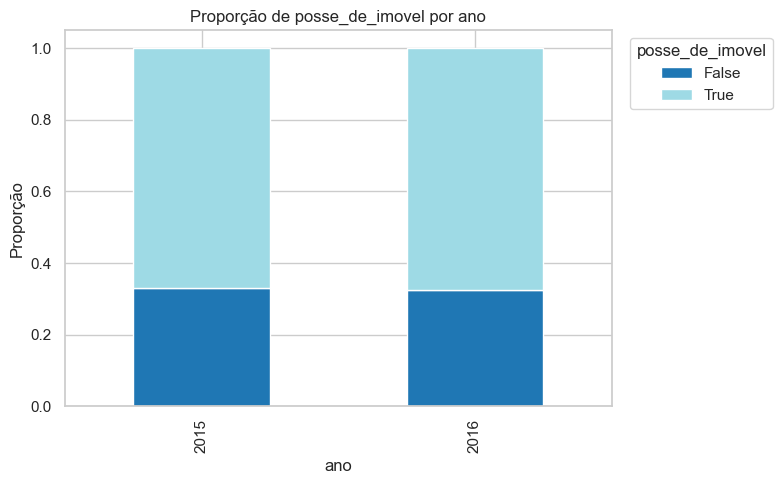

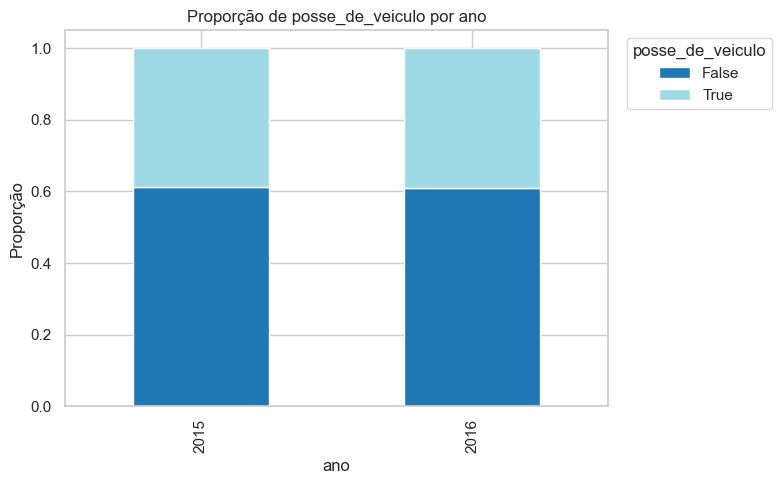

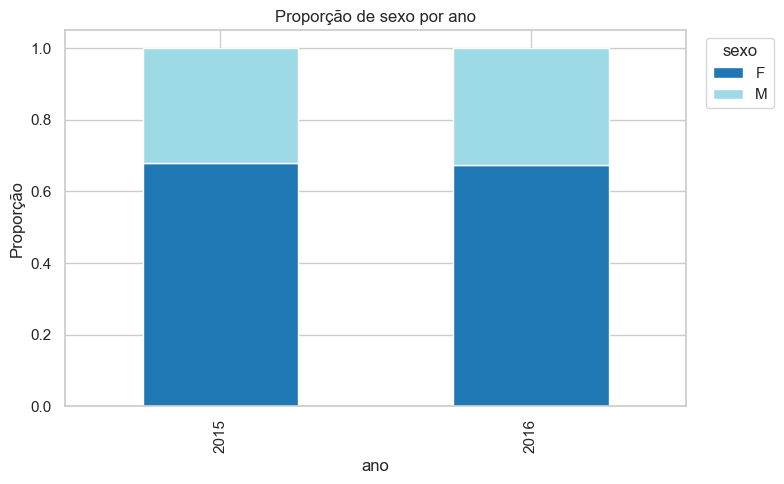

In [62]:
def plot_stacked_prop(df, cat_col, year_col='ano', figsize=(8,5)):
    pivot = (df.groupby([year_col, cat_col]).size()
               .unstack(fill_value=0))
    prop = pivot.div(pivot.sum(axis=1), axis=0)  # proporção por ano
    prop.plot(kind='bar', stacked=True, figsize=figsize, colormap='tab20')
    plt.title(f'Proporção de {cat_col} por {year_col}')
    plt.ylabel('Proporção')
    plt.xlabel(year_col)
    plt.legend(title=cat_col, bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()

for col in ['posse_de_imovel','posse_de_veiculo','sexo']:
    plot_stacked_prop(previsao_de_renda, col)
    plt.show()

2. Para cada variável qualitativa, construa um gráfico mostrando as médias de cada nível da variável no tempo e avalie a estabilidade. Houve alguma alteração importante? Você acha que se pode utilizar essas variáveis em uma modelagem?


Resumo educacao — 2015 vs 2016:


,prop_2015%,prop_2016%,diff_pp,count_2015,count_2016
educacao,,,,,
Superior completo,32.71,44.57,11.86,3925,1337
Superior incompleto,3.91,4.33,0.43,469,130
Pós graduação,0.13,0.10,-0.03,16,3
Primário,1.31,1.20,-0.11,157,36
Secundário,61.94,49.80,-12.14,7433,1494


chi2 = 157.171, p-value = 0.0000


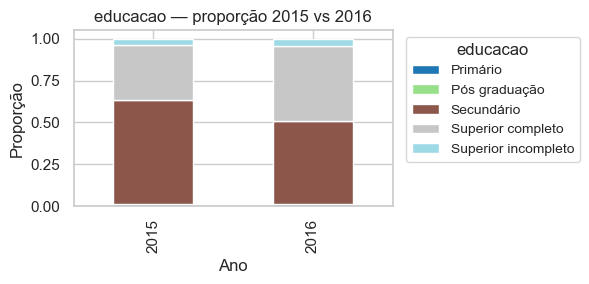

In [91]:
col_to_analyze = 'educacao'  # <-- mude para a coluna desejada

# preparar ano
previsao_de_renda['data_ref'] = pd.to_datetime(previsao_de_renda['data_ref'], errors='coerce')
previsao_de_renda['ano'] = previsao_de_renda['data_ref'].dt.year

# filtrar e formatar
df = previsao_de_renda.dropna(subset=['ano']).copy()
df['ano'] = df['ano'].astype(int)
df[col_to_analyze] = df[col_to_analyze].fillna('NaN').astype(str)

# contagens e proporções
counts = df.groupby(['ano', col_to_analyze]).size().unstack(fill_value=0).reindex(index=sorted(df['ano'].unique()))
props = counts.div(counts.sum(axis=1), axis=0)

# verificar anos 2015 e 2016
year_a, year_b = 2015, 2016
if year_a not in props.index or year_b not in props.index:
    print(f"Ano(s) {year_a}/{year_b} não disponíveis. Anos presentes: {list(props.index)}")
else:
    pct_a = props.loc[year_a]
    pct_b = props.loc[year_b]
    diff_pp = (pct_b - pct_a) * 100

    summary = pd.DataFrame({
        f'prop_{year_a}%': (pct_a*100).round(2),
        f'prop_{year_b}%': (pct_b*100).round(2),
        'diff_pp': diff_pp.round(2),
        f'count_{year_a}': counts.loc[year_a],
        f'count_{year_b}': counts.loc[year_b]
    }).sort_values('diff_pp', ascending=False)

    print(f"\nResumo {col_to_analyze} — {year_a} vs {year_b}:")
    display(summary)

    # teste qui-quadrado
    obs = df[df['ano'].isin([year_a, year_b])].groupby([col_to_analyze, 'ano']).size().unstack(fill_value=0)
    obs = obs.loc[obs.sum(axis=1) > 0]
    if obs.shape[0] >= 2 and obs.shape[1] >= 2:
        chi2, p, dof, expected = chi2_contingency(obs)
        print(f"chi2 = {chi2:.3f}, p-value = {p:.4f}")
    else:
        print("Dados insuficientes para teste qui-quadrado.")

    # plot compacto
    ax = props.loc[[year_a, year_b]].plot(kind='bar', stacked=True, figsize=(6,3), colormap='tab20')
    ax.set_title(f'{col_to_analyze} — proporção {year_a} vs {year_b}')
    ax.set_ylabel('Proporção')
    ax.set_xlabel('Ano')
    ax.legend(title=col_to_analyze, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


Resumo tipo_residencia — 2015 vs 2016:


,prop_2015%,prop_2016%,diff_pp,count_2015,count_2016
tipo_residencia,,,,,
Aluguel,1.14,1.57,0.42,137,47
Governamental,2.92,3.07,0.14,351,92
Comunitário,0.41,0.47,0.06,49,14
Estúdio,0.72,0.70,-0.02,86,21
Com os pais,4.28,4.13,-0.14,513,124
Casa,90.53,90.07,-0.47,10864,2702


chi2 = 4.072, p-value = 0.5391


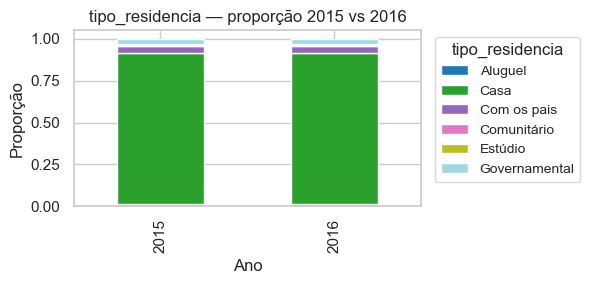

In [93]:
col_to_analyze = 'tipo_residencia'  
# Preparar coluna ano a partir de data_ref
previsao_de_renda['data_ref'] = pd.to_datetime(previsao_de_renda['data_ref'], errors='coerce')
previsao_de_renda['ano'] = previsao_de_renda['data_ref'].dt.year

# Filtrar e formatar
df = previsao_de_renda.dropna(subset=['ano']).copy()
df['ano'] = df['ano'].astype(int)
df[col_to_analyze] = df[col_to_analyze].fillna('NaN').astype(str)

# Contagens e proporções por ano
counts = df.groupby(['ano', col_to_analyze]).size().unstack(fill_value=0).reindex(index=sorted(df['ano'].unique()))
props = counts.div(counts.sum(axis=1), axis=0)

# Anos a comparar
year_a, year_b = 2015, 2016

# Verificar disponibilidade dos anos
if year_a not in props.index or year_b not in props.index:
    print(f"Ano(s) {year_a}/{year_b} não disponíveis. Anos presentes: {list(props.index)}")
else:
    # Tabela resumo (pontos percentuais e contagens)
    pct_a = props.loc[year_a]
    pct_b = props.loc[year_b]
    diff_pp = (pct_b - pct_a) * 100

    summary = pd.DataFrame({
        f'prop_{year_a}%': (pct_a*100).round(2),
        f'prop_{year_b}%': (pct_b*100).round(2),
        'diff_pp': diff_pp.round(2),
        f'count_{year_a}': counts.loc[year_a],
        f'count_{year_b}': counts.loc[year_b]
    }).sort_values('diff_pp', ascending=False)

    print(f"\nResumo {col_to_analyze} — {year_a} vs {year_b}:")
    display(summary)

    # Teste qui-quadrado entre os dois anos
    obs = df[df['ano'].isin([year_a, year_b])].groupby([col_to_analyze, 'ano']).size().unstack(fill_value=0)
    obs = obs.loc[obs.sum(axis=1) > 0]
    if obs.shape[0] >= 2 and obs.shape[1] >= 2:
        chi2, p, dof, expected = chi2_contingency(obs)
        print(f"chi2 = {chi2:.3f}, p-value = {p:.4f}")
    else:
        print("Dados insuficientes para teste qui-quadrado (poucas categorias/anos).")

    # Gráfico compacto das proporções (sem rolagem longa)
    ax = props.loc[[year_a, year_b]].plot(kind='bar', stacked=True, figsize=(6,3), colormap='tab20')
    ax.set_title(f'{col_to_analyze} — proporção {year_a} vs {year_b}')
    ax.set_ylabel('Proporção')
    ax.set_xlabel('Ano')
    ax.legend(title=col_to_analyze, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


Resumo tipo_renda — 2015 vs 2016:


,prop_2015%,prop_2016%,diff_pp,count_2015,count_2016
tipo_renda,,,,,
Empresário,21.76,23.33,1.58,2611,700
Bolsista,0.03,0.00,-0.03,4,0
Assalariado,52.23,51.93,-0.30,6268,1558
Servidor público,8.88,8.33,-0.55,1066,250
Pensionista,17.09,16.40,-0.69,2051,492


chi2 = 5.243, p-value = 0.2632


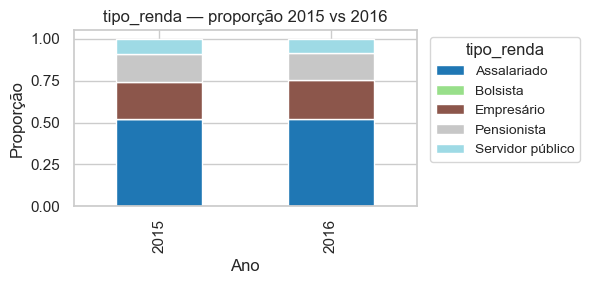

In [96]:
col_to_analyze = 'tipo_renda'  
# Preparar coluna ano a partir de data_ref
previsao_de_renda['data_ref'] = pd.to_datetime(previsao_de_renda['data_ref'], errors='coerce')
previsao_de_renda['ano'] = previsao_de_renda['data_ref'].dt.year

# Filtrar e formatar
df = previsao_de_renda.dropna(subset=['ano']).copy()
df['ano'] = df['ano'].astype(int)
df[col_to_analyze] = df[col_to_analyze].fillna('NaN').astype(str)

# Contagens e proporções por ano
counts = df.groupby(['ano', col_to_analyze]).size().unstack(fill_value=0).reindex(index=sorted(df['ano'].unique()))
props = counts.div(counts.sum(axis=1), axis=0)

# Anos a comparar
year_a, year_b = 2015, 2016

# Verificar disponibilidade dos anos
if year_a not in props.index or year_b not in props.index:
    print(f"Ano(s) {year_a}/{year_b} não disponíveis. Anos presentes: {list(props.index)}")
else:
    # Tabela resumo (pontos percentuais e contagens)
    pct_a = props.loc[year_a]
    pct_b = props.loc[year_b]
    diff_pp = (pct_b - pct_a) * 100

    summary = pd.DataFrame({
        f'prop_{year_a}%': (pct_a*100).round(2),
        f'prop_{year_b}%': (pct_b*100).round(2),
        'diff_pp': diff_pp.round(2),
        f'count_{year_a}': counts.loc[year_a],
        f'count_{year_b}': counts.loc[year_b]
    }).sort_values('diff_pp', ascending=False)

    print(f"\nResumo {col_to_analyze} — {year_a} vs {year_b}:")
    display(summary)

    # Teste qui-quadrado entre os dois anos
    obs = df[df['ano'].isin([year_a, year_b])].groupby([col_to_analyze, 'ano']).size().unstack(fill_value=0)
    obs = obs.loc[obs.sum(axis=1) > 0]
    if obs.shape[0] >= 2 and obs.shape[1] >= 2:
        chi2, p, dof, expected = chi2_contingency(obs)
        print(f"chi2 = {chi2:.3f}, p-value = {p:.4f}")
    else:
        print("Dados insuficientes para teste qui-quadrado (poucas categorias/anos).")

    # Gráfico compacto das proporções (sem rolagem longa)
    ax = props.loc[[year_a, year_b]].plot(kind='bar', stacked=True, figsize=(6,3), colormap='tab20')
    ax.set_title(f'{col_to_analyze} — proporção {year_a} vs {year_b}')
    ax.set_ylabel('Proporção')
    ax.set_xlabel('Ano')
    ax.legend(title=col_to_analyze, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


Resumo estado_civil — 2015 vs 2016:


,prop_2015%,prop_2016%,diff_pp,count_2015,count_2016
estado_civil,,,,,
Casado,70.18,70.93,0.75,8422,2128
Separado,5.44,6.17,0.72,653,185
Solteiro,11.75,11.90,0.15,1410,357
Viúvo,4.62,4.07,-0.56,555,122
União,8.00,6.93,-1.07,960,208


chi2 = 7.660, p-value = 0.1048


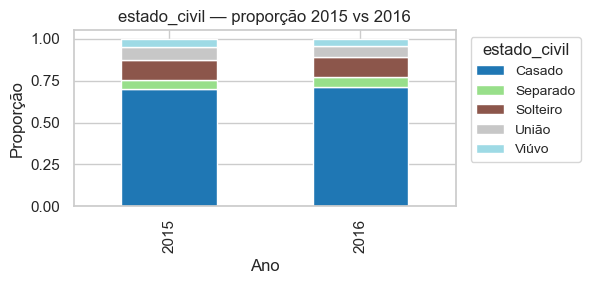

In [100]:
col_to_analyze = 'estado_civil'  
# Preparar coluna ano a partir de data_ref
previsao_de_renda['data_ref'] = pd.to_datetime(previsao_de_renda['data_ref'], errors='coerce')
previsao_de_renda['ano'] = previsao_de_renda['data_ref'].dt.year

# Filtrar e formatar
df = previsao_de_renda.dropna(subset=['ano']).copy()
df['ano'] = df['ano'].astype(int)
df[col_to_analyze] = df[col_to_analyze].fillna('NaN').astype(str)

# Contagens e proporções por ano
counts = df.groupby(['ano', col_to_analyze]).size().unstack(fill_value=0).reindex(index=sorted(df['ano'].unique()))
props = counts.div(counts.sum(axis=1), axis=0)

# Anos a comparar
year_a, year_b = 2015, 2016

# Verificar disponibilidade dos anos
if year_a not in props.index or year_b not in props.index:
    print(f"Ano(s) {year_a}/{year_b} não disponíveis. Anos presentes: {list(props.index)}")
else:
    # Tabela resumo (pontos percentuais e contagens)
    pct_a = props.loc[year_a]
    pct_b = props.loc[year_b]
    diff_pp = (pct_b - pct_a) * 100

    summary = pd.DataFrame({
        f'prop_{year_a}%': (pct_a*100).round(2),
        f'prop_{year_b}%': (pct_b*100).round(2),
        'diff_pp': diff_pp.round(2),
        f'count_{year_a}': counts.loc[year_a],
        f'count_{year_b}': counts.loc[year_b]
    }).sort_values('diff_pp', ascending=False)

    print(f"\nResumo {col_to_analyze} — {year_a} vs {year_b}:")
    display(summary)

    # Teste qui-quadrado entre os dois anos
    obs = df[df['ano'].isin([year_a, year_b])].groupby([col_to_analyze, 'ano']).size().unstack(fill_value=0)
    obs = obs.loc[obs.sum(axis=1) > 0]
    if obs.shape[0] >= 2 and obs.shape[1] >= 2:
        chi2, p, dof, expected = chi2_contingency(obs)
        print(f"chi2 = {chi2:.3f}, p-value = {p:.4f}")
    else:
        print("Dados insuficientes para teste qui-quadrado (poucas categorias/anos).")

    # Gráfico compacto das proporções (sem rolagem longa)
    ax = props.loc[[year_a, year_b]].plot(kind='bar', stacked=True, figsize=(6,3), colormap='tab20')
    ax.set_title(f'{col_to_analyze} — proporção {year_a} vs {year_b}')
    ax.set_ylabel('Proporção')
    ax.set_xlabel('Ano')
    ax.legend(title=col_to_analyze, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

## Insights

    • Variáveis estáveis: posse_de_imovel, posse_de_veiculo e sexo mostraram proporções muito semelhantes entre 2015 e 2016 — sem sinal de mudança relevante.
    • Mudanças pequenas e não significativas: tipo_renda apresentou variações pequenas por categoria e p‑value alto (não significativo), logo não há evidência forte de alteração estrutural.
    • Mudança importante: educacao mostrou uma alteração grande.